In [67]:
%matplotlib inline
from __future__ import division

import numpy as np
import pandas as pd
import json
import csv
import seaborn as sns #MA
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier #MA
from sklearn.svm import SVC

# Ensemble methods
from sklearn.ensemble import RandomForestClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from scipy.stats import uniform

import pydot

In [68]:
# Load json dataset into pandas
train = pd.read_json('train.json', convert_dates=['unix_timestamp_of_request'])
test = pd.read_json('test.json', convert_dates=['unix_timestamp_of_request'])

In [69]:
# There are more columns in the train dataset than there are in the test dataset.  Remove the features
# that aren't available in the test dataset because we won't be able to use them in the model
def remove_train_features():
    data_cols = set(train.columns.values)
    test_cols = set(test.columns.values)
    trim_data_cols = data_cols.intersection(test_cols)
    return list(trim_data_cols)

trim_data_cols = remove_train_features()
trim_data_cols.append('requester_received_pizza') 
train = train[trim_data_cols]

In [70]:
import re
def get_word_counts(df, word_list):
    entry_count = []
    for entry in df.all_text:
        word_dict = dict((x,0) for x in word_list)
        for word in re.findall(r"\w+", entry):
            if word in word_dict:
                word_dict[word] += 1
        entry_count.append(sum(word_dict.values()))
    return pd.Series(entry_count)

In [71]:
# Topics and keywords from paper
job = ['work', 'paycheck', 'unemployment', 'interview', 'fired', 'unemployment', 'hire', 'hired']
money = ['money', 'now', 'broke', 'week', 'until', 'time', 'last', 'day', 'when', 'today', 'tonight', 'paid', 'next', 'first', 'night', 'after', 'tomorrow', 'month', 'while', 'account', 'before', 'long', 'Friday', 'rent', 'buy', 'bank', 'still', 'bills', 'ago', 'cash', 'due', 'past', 'never', 'paycheck', 'check', 'spent', 'years', 'poor', 'till', 'yesterday', 'morning', 'dollars', 'financial', 'hour', 'bill', 'evening', 'credit', 'budget', 'loan', 'bucks', 'deposit', 'dollar', 'current', 'payed']
student = ['college', 'student', 'school', 'roommate', 'studying', 'semester', 'university', 'finals', 'study', 'class', 'project', 'dorm', 'tuition']
family = ['family', 'mom', 'wife', 'wifey', 'parents', 'mother', 'husband', 'dad', 'son', 'daughter', 'father', 'parent', 'mom', 'baby', 'born', 'newborn', 'kid', 'children', 'child']
craving = ['friend', 'girlfriend', 'craving', 'birthday', 'boyfriend', 'celebrate', 'party', 'game', 'games', 'movie', 'date', 'drunk', 'beer', 'celebrating', 'invited', 'drinks', 'crave', 'wasted', 'invite']
gratitude = ['pay', 'forward', 'thank', 'thanks', 'blessed', 'bless', 'grateful', 'reciprocate', 'back', 'teach']
food = ['vegetable', 'vegetables', 'ramen', 'oatmeal']
pos_words = ['jpg', 'trade', 'blue', 'use', 'make', 'pretty', 'forward', 'friday', 'boyfriend', 'll', 'scarf']

In [72]:
# Feature creation
def encode_features(df, fte):
    '''create dummy variables for categorical data'''
    for feature in fte:
        df = df.join(pd.get_dummies(df[feature], prefix=feature))
    return df

def preprocess(df):
    df['karma_cat_2'] = np.where(df.requester_upvotes_minus_downvotes_at_request <= 10, 0, 1)
    df['all_text'] = [df.request_title.iloc[[i]].tolist()[0] + ' ' + df.request_text_edit_aware.iloc[[i]].tolist()[0]
                    for i in range(df.shape[0])]
    df['job_c'] = get_word_counts(df, job)
    df['money_c'] = get_word_counts(df, money)
    df['student_c'] = get_word_counts(df, student)
    df['family_c'] = get_word_counts(df, family)
    df['craving_c'] = get_word_counts(df, craving)
    df['gratitude_c'] = get_word_counts(df, gratitude)
    df['food_c'] = get_word_counts(df, food)
    df['pos_words'] = get_word_counts(df, pos_words)
    df['exclamation_c'] = map(lambda x: len(re.findall(r'(!)|(:\))', x)), df['all_text'])
    df['post_length'] = df['request_text_edit_aware'].map(lambda x: len(x))
    df['request_title_length'] = df['request_title'].map(lambda x: len(x))
    df['link'] = map(lambda x: 1 if x.find('http') > 0 else 0, df['request_text_edit_aware'])
    df['img'] = map(lambda x: 1 if x.find('img') > 0 else 0, df['request_text_edit_aware'])
    df['weekday'] = map(lambda x: x.weekday(), df['unix_timestamp_of_request'])
    df['month'] = map(lambda x: x.month, df['unix_timestamp_of_request'])
    df['hour'] = map(lambda x: x.hour, df['unix_timestamp_of_request'])
    df['afternoon'] = map(lambda x: 1 if (x >= 13 and x <= 19) else 0, df['hour'])
    df['link_or_img'] = map(lambda x: 1 if x.find('img') > 0 or x.find('http') > 0 else 0, df['request_text_edit_aware'])
    df['time_c'] = map(lambda x: 1 if x >= 1342561000 else 0, df['unix_timestamp_of_request_utc'])

    
    # MA:  a few time variables and a few joint variables 
    df['evening'] = map(lambda x: 1 if (x >= 19 and x <= 23) else 0, df['hour'])
    df['dayct'] = map(lambda x: x.day, df['unix_timestamp_of_request'])
    df['firsthalf'] = map(lambda x: 1 if (x <= 15 ) else 0, df['dayct'])

    t1 = df['requester_account_age_in_days_at_request']
    t2 = df['requester_number_of_comments_at_request']
    t3 = df['requester_number_of_posts_at_request']
    t4 = df['requester_number_of_subreddits_at_request']

    t5 = df['requester_number_of_comments_in_raop_at_request']
    t6 = df['requester_number_of_posts_on_raop_at_request']
    t7 = df['requester_days_since_first_post_on_raop_at_request']

    t8 = df['requester_upvotes_minus_downvotes_at_request']
    t9 = df['requester_upvotes_plus_downvotes_at_request']

    t_newacct = np.zeros(len(t1))
    t_novotes = np.zeros(len(t1))
    t_inactive = np.zeros(len(t1))
    t_inact_raop = np.zeros(len(t1))

    for i in range(len(t1)):
        if int(t1[i]) == 0:
            t_newacct[i] = 1
        if t2[i] == 0 and t3[i] == 0 and t4[i] == 0:
            t_inactive[i] = 1
        t0 = int(t7[i])    
        if t5[i] == 0 and t6[i] == 0 and t0 == 0:
            t_inact_raop[i] = 1
        if t8[i] == 0 and t9[i] == 0:
            t_novotes[i] = 1
        #print t2[i], t3[i], t4[i],t_inactive[i]  #t5[i], t6[i], t7[i], t8[i], t9[i]

    df['newacct'] = t_newacct
    df['inactive'] = t_inactive
    df['inact_raop'] = t_inact_raop
    df['novotes'] = t_novotes
    
    features_to_encode = ['weekday', 'hour', 'month']
    encode_features(df, features_to_encode)
    
    return df

In [74]:
train_preprocess = preprocess(train)
test_preprocess = preprocess(test)

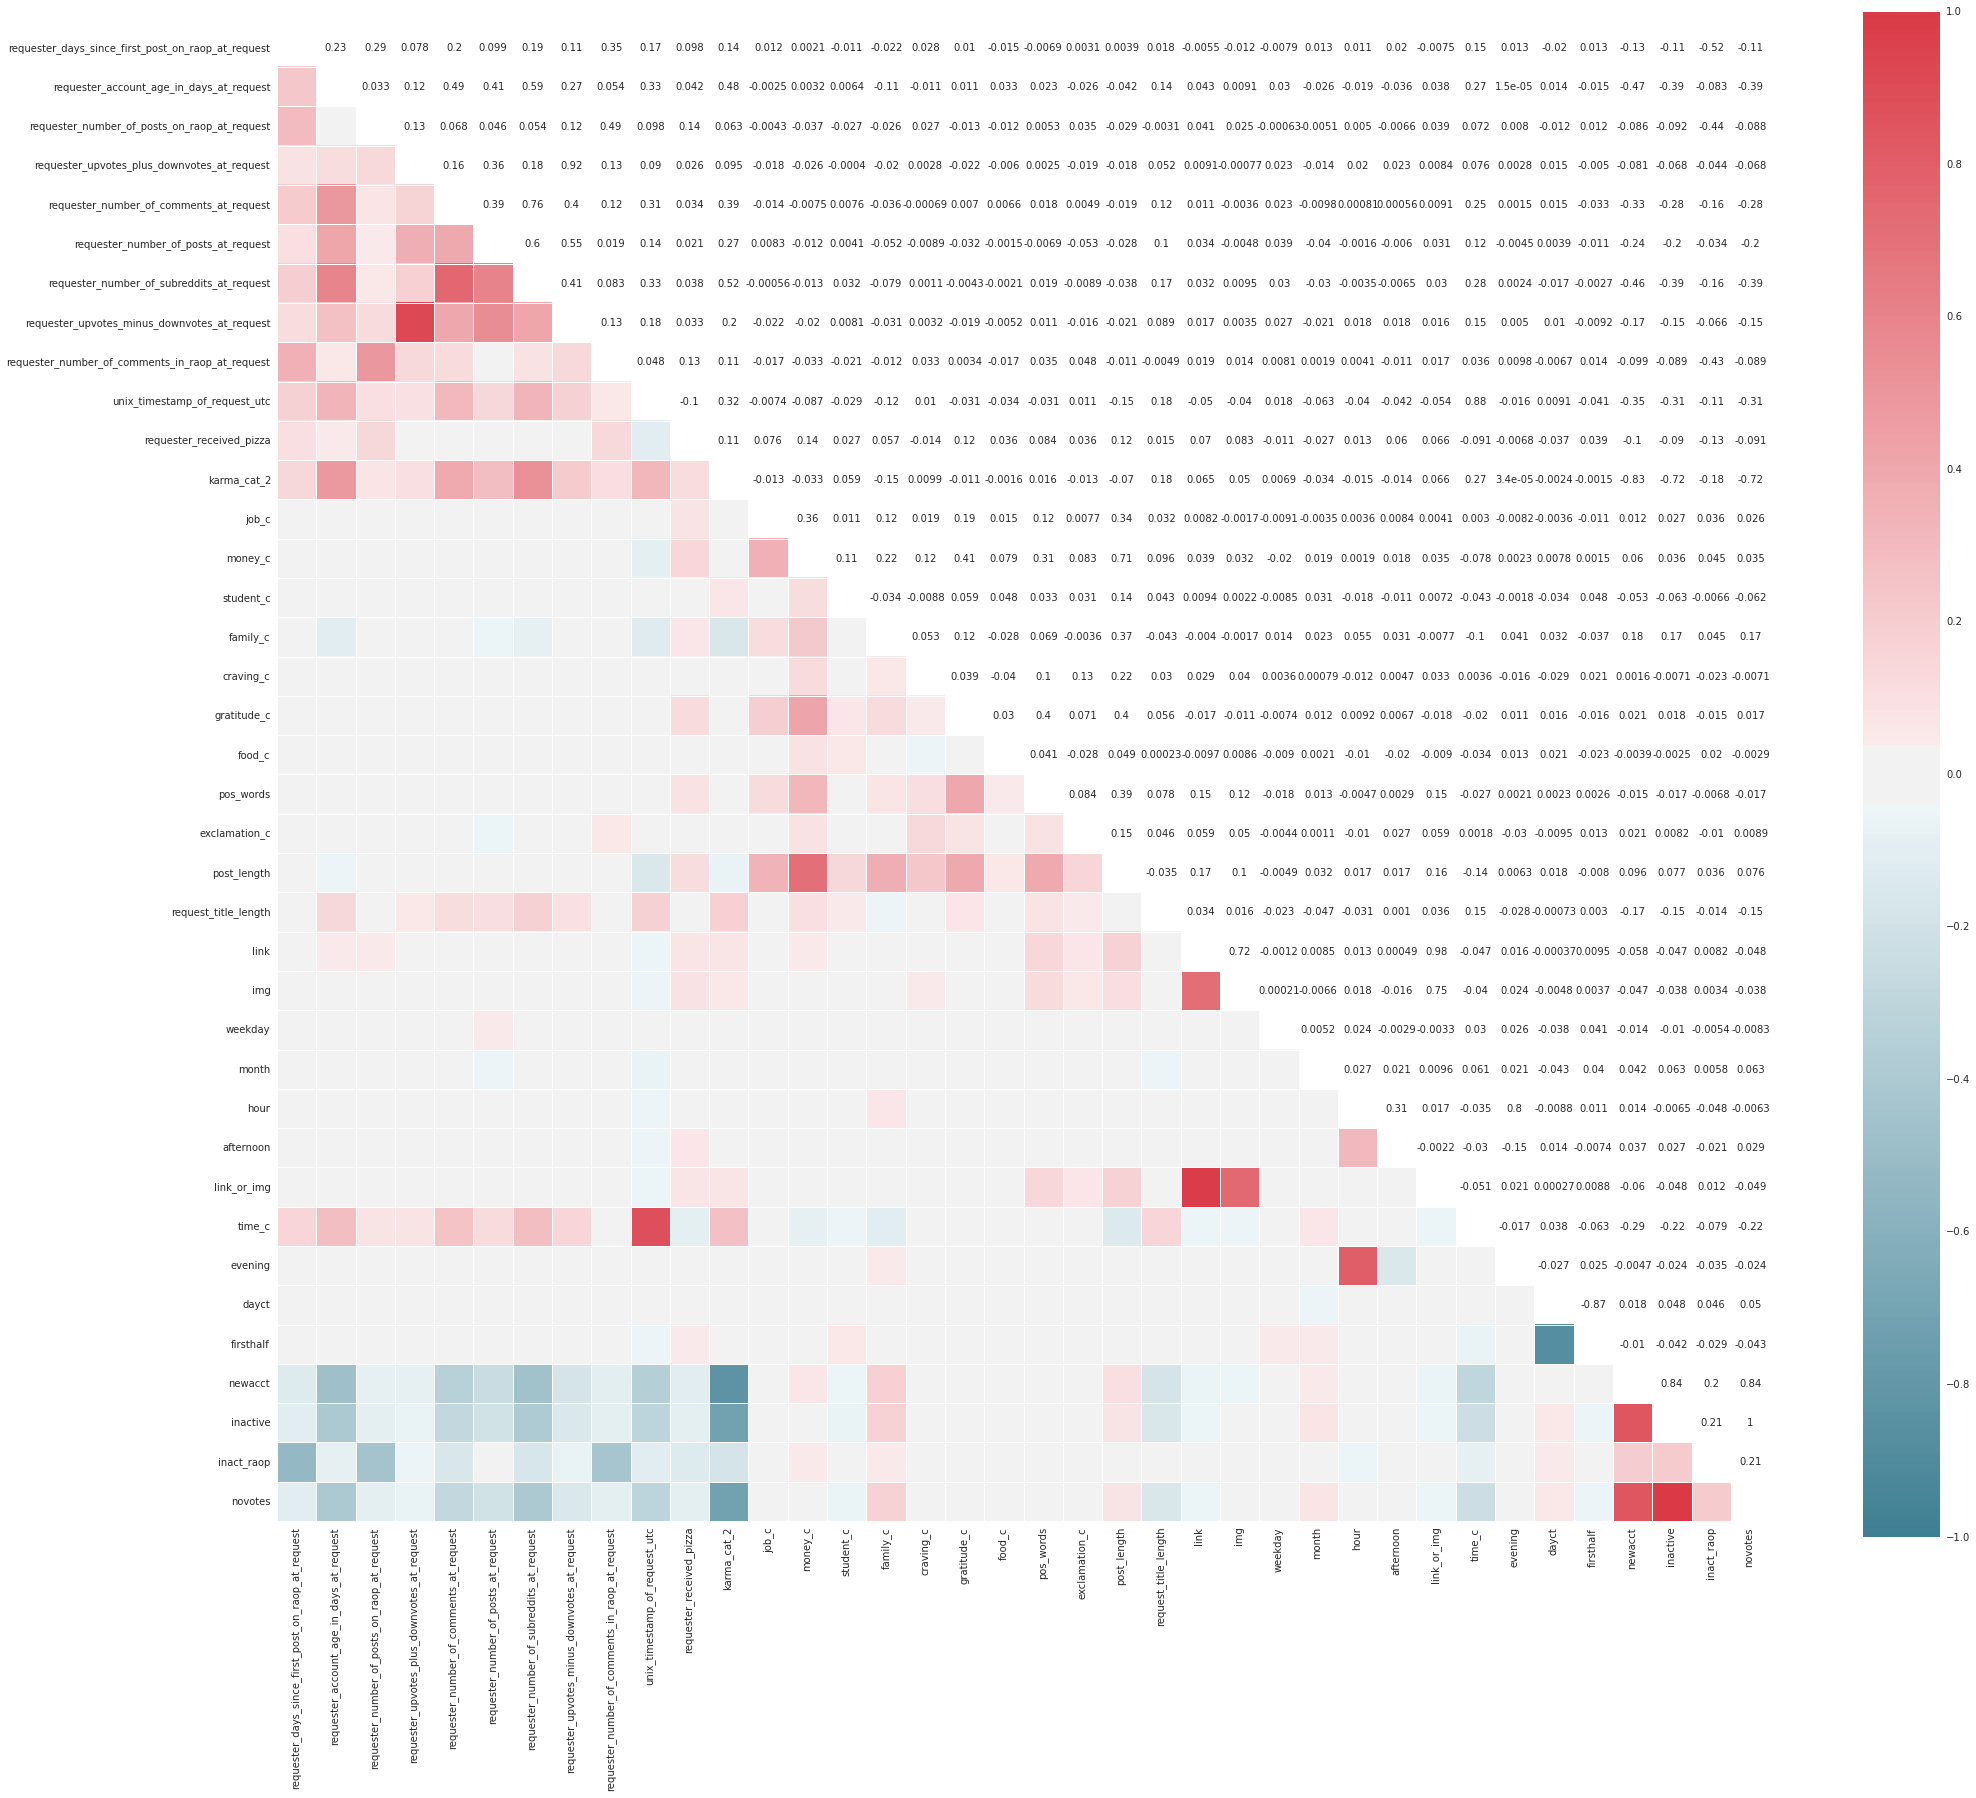

In [75]:
# Correlation heatmap all features 
train_data_names = list(train.columns.values)
fig, ax = plt.subplots(figsize=(30, 30), dpi=80)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.corrplot(train, names=train_data_names, annot=True, sig_stars=False,
             diag_names=False, cmap=cmap, ax=ax)
fig.tight_layout()

In [76]:
features = ['karma_cat_2', 'afternoon', 'link', 'img', 'gratitude_c',
                   'post_length', 'requester_number_of_posts_on_raop_at_request',
                   'job_c', 'money_c', 'family_c', 'student_c', 'craving_c', 'request_title_length',
                   'requester_number_of_comments_in_raop_at_request', 'time_c',
                   'newacct', 'inactive', 'inact_raop', 'novotes', 'evening', 'firsthalf'
           ]

train_pre = preprocess(train)
test_pre = preprocess(test)

train_pre = train_pre[features]
test_pre = test_pre[features]

scaler = scalar = preprocessing.StandardScaler()
scaler.fit(train_pre.values)

train_sc = scalar.transform(train_pre.values)

np.random.seed(0)
shuffle = np.random.permutation(np.arange(train.shape[0]))

# Pull out text features
train_length = 3230
data_mat, labels = train_sc[shuffle], train.requester_received_pizza.values[shuffle]

# shuffle training data for error analysis
data_shuffle = pd.DataFrame(train, index=shuffle)

train_data, train_labels = data_mat[:train_length], labels[:train_length]
dev_data, dev_labels = data_mat[train_length:], labels[train_length:]

test_data = scalar.transform(test_pre.values)

In [86]:
def ada_boost():
    
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=290)
    scores = cross_val_score(clf, train_data, train_labels)
    print scores
    clf.fit(train_data, train_labels)
    pred = clf.predict(dev_data)
    print clf.score(dev_data, dev_labels)
    print classification_report(pred, dev_labels)

    cm = confusion_matrix(dev_labels, pred)
    print(cm)
    
    for i in range(len(pred)):
        if pred[i] == 0 and dev_labels[i] == 1:
            #print data_shuffle.all_text.iloc[[i]].tolist()[0]
            pass
    return clf

ada = ada_boost()

[ 0.75116063  0.75487465  0.74814126]
0.769135802469
             precision    recall  f1-score   support

      False       0.96      0.78      0.86       743
       True       0.20      0.61      0.30        67

avg / total       0.89      0.77      0.82       810

[[582  26]
 [161  41]]


In [29]:
#test_preds = map(lambda x: 1 if x == True else 0, ada.predict(test_data))
test_preds = map(lambda x: 1 if x == True else 0, grad.predict(test_data)) #MA
request_ids = test['request_id'].values

In [31]:
with open('submission.csv', 'wb') as csvfile:
    outputwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    outputwriter.writerow(['request_id'] + ['requester_received_pizza'])
    
    for i in range(len(request_ids)):
        outputwriter.writerow([request_ids[i], str(test_preds[i])])


In [87]:
def gradient_boost():
    
    clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.15, n_estimators=20, 
        min_samples_split=2,subsample=0.3, min_samples_leaf=1,
        max_depth=3, init=None, random_state=None, max_features=None,verbose=2)
    scores = cross_val_score(clf, train_data, train_labels)
    print scores
    clf.fit(train_data, train_labels)
    pred = clf.predict(dev_data)
    print clf.score(dev_data, dev_labels)
    print classification_report(pred, dev_labels)

    cm = confusion_matrix(dev_labels, pred)
    print(cm)
    
    for i in range(len(pred)):
        if pred[i] == 0 and dev_labels[i] == 1:
            #print data_shuffle.all_text.iloc[[i]].tolist()[0]
            pass
    return clf

grad = gradient_boost()


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.0424           0.0116            0.09s
         2           1.1036           0.0071            0.06s
         3           1.0645           0.0117            0.06s
         4           1.0683           0.0102            0.05s
         5           0.9873           0.0057            0.05s
         6           1.0526           0.0005            0.04s
         7           1.0417           0.0001            0.04s
         8           1.0548          -0.0033            0.04s
         9           1.0117           0.0015            0.04s
        10           1.0435          -0.0012            0.03s
        11           1.0334           0.0023            0.03s
        12           1.0204          -0.0010            0.02s
        13           0.9686           0.0018            0.02s
        14           1.0022          -0.0007            0.02s
        15           0.9806          -0.0027            0.01s
       

In [89]:
def random_forest():
    
    forest = RandomForestClassifier(n_estimators = 30)
    scores = cross_val_score(forest, train_data, train_labels)
    print scores
    forest.fit(train_data, train_labels)
    pred = forest.predict(dev_data)
    print forest.score(dev_data, dev_labels)
    print classification_report(pred, dev_labels)

    cm = confusion_matrix(dev_labels, pred)
    print(cm)
    
    for i in range(len(pred)):
        if pred[i] == 0 and dev_labels[i] == 1:
            #print data_shuffle.all_text.iloc[[i]].tolist()[0]
            pass
    return forest

forest = random_forest()

[ 0.75301764  0.75858867  0.73698885]
0.73950617284
             precision    recall  f1-score   support

      False       0.95      0.76      0.84       753
       True       0.12      0.42      0.19        57

avg / total       0.89      0.74      0.80       810

[[575  33]
 [178  24]]


In [92]:
def bag_DecTree():

#    ensemble = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5, 
    ensemble = BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, max_features=0.5,                          
                             bootstrap=True,
                             bootstrap_features=False,
                             oob_score=True)
    scores = cross_val_score(ensemble, train_data, train_labels)
    print scores
    ensemble.fit(train_data, train_labels)
    
    pred = ensemble.predict(dev_data)
    print ensemble.score(dev_data, dev_labels)
    print classification_report(pred, dev_labels)

    cm = confusion_matrix(dev_labels, pred)
    print(cm)
    
    for i in range(len(pred)):
        if pred[i] == 0 and dev_labels[i] == 1:
            #print data_shuffle.all_text.iloc[[i]].tolist()[0]
            pass
    return ensemble

bDT = bag_DecTree()


[ 0.73259053  0.74930362  0.74256506]
0.745679012346
             precision    recall  f1-score   support

      False       0.96      0.76      0.85       760
       True       0.11      0.46      0.18        50

avg / total       0.90      0.75      0.81       810

[[581  27]
 [179  23]]


In [81]:
def logReg():

    logReg = LogisticRegression(C=1, penalty='l2')
    scores = cross_val_score(logReg, train_data, train_labels)
    print scores
    logReg.fit(train_data, train_labels)
    
    pred = logReg.predict(dev_data)
    print logReg.score(dev_data, dev_labels)
    print classification_report(pred, dev_labels)

    cm = confusion_matrix(dev_labels, pred)
    print(cm)
    
    for i in range(len(pred)):
        if pred[i] == 0 and dev_labels[i] == 1:
            #print data_shuffle.all_text.iloc[[i]].tolist()[0]
            pass
    return logReg

LR = logReg()

[ 0.75858867  0.77344475  0.74814126]
0.762962962963
             precision    recall  f1-score   support

      False       0.98      0.77      0.86       772
       True       0.12      0.63      0.20        38

avg / total       0.94      0.76      0.83       810

[[594  14]
 [178  24]]


In [ ]:
# library("psych", lib.loc="~/R/win-library/2.15")
library("sqldf", lib.loc="~/R/win-library/2.15")
library("Hmisc", lib.loc="~/R/win-library/2.15")
options(scipen=999)

testset <-  fromJSON("C:/Users/Murat Aydogdu/Google Drive/UCB_MIDS_StartingSummer2014/2015_Spring/W207_ItML/FinalProject/test.json")
trainset <-  fromJSON("C:/Users/Murat Aydogdu/Google Drive/UCB_MIDS_StartingSummer2014/2015_Spring/W207_ItML/FinalProject/train.json")

names(testset)
names(trainset)

summary(trainset)
attributes(trainset)

table(trainset$request_text)
table(trainset$request_text_edit_aware)
table(trainset$request_title)

table(trainset$requester_number_of_comments_in_raop_at_request)
/* 0    1    2    3    4    5    6    7    8    9   10   11   12   13 
/* 3453  240   98   61   49   26   17   13   16    9    6    5   10    5 

table(trainset$requester_number_of_posts_at_request)
/* 0    1    2    3    4    5    6    7    8    9   10   11   12   13 
/* 1198  293  218  167  131  106  104  101   73   64   69   60   52   62 

table(trainset$requester_number_of_posts_on_raop_at_request)
/* 0    1    2    3    4    5 
/* 3848  146   34    8    1    3 

table(trainset$requester_number_of_subreddits_at_request)
/* 0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17 
/* 729 362 128 119 101  90 107 102  83  81 104  82  79  60  73  77  53  62

table(trainset$requester_received_pizza)
/* FALSE  TRUE 
/* 3046   994 

table(trainset$requester_user_flair)
/* PIF shroom 
/* 59    935 

/* Data exploration using psych package
describe(trainset$number_of_downvotes_of_request_at_retrieval) 
describe(trainset$number_of_upvotes_of_request_at_retrieval)
describe(trainset$post_was_edited)    
describe(trainset$request_number_of_comments_at_retrieval)

describe(trainset$requester_account_age_in_days_at_request)
/* n missing  unique    Mean     .05     .10     .25     .50     .75     .90     .95 
/* 4040     0    3140   254.6   0.000   0.000   3.473 157.067 390.093 658.154 855.922 
/* lowest :    0.000000    0.002280    0.004537    0.009306    0.010995
/* highest: 1992.518657 2061.458067 2124.362650 2521.263206 2809.750787

describe(trainset$requester_number_of_comments_at_request)
/* n missing  unique    Mean     .05     .10     .25     .50     .75     .90     .95 
/* 4040    0     631   115.1     0.0     0.0     0.0    24.0   140.2   379.2   580.0 
/* lowest :   0   1   2   3   4, highest: 976 981 990 992 994
describe(trainset$requester_number_of_posts_at_request)
/* n missing  unique    Mean     .05     .10     .25     .50     .75     .90     .95 
/* 4040    0     216    21.6       0       0       0       5      22      57      95 
/* lowest :   0   1   2   3   4, highest: 612 627 809 824 867
describe(trainset$requester_number_of_subreddits_at_request)
/* n missing  unique    Mean     .05     .10     .25     .50     .75     .90     .95 
/* 4040    0     128   18.08       0       0       1      11      27      46      62 
/* lowest :   0   1   2   3   4, highest: 133 137 149 162 186

describe(trainset$requester_days_since_first_post_on_raop_at_request)
/* n missing  unique    Mean     .05     .10     .25     .50     .75     .90     .95 
/* 4040    0     666   16.42    0.00    0.00    0.00    0.00    0.00   21.84   92.14 
/* lowest :   0.000000   0.000625   0.001377   0.001968   0.002280
/* highest: 689.326713 711.177037 711.307627 739.771007 785.457685 

describe(trainset$requester_number_of_comments_in_raop_at_request)
/* n missing  unique    Mean     .05     .10     .25     .50     .75     .90     .95 
/* 4040    0      34   0.645       0       0       0       0       0       1       3 
/* lowest :  0  1  2  3  4, highest: 52 54 56 77 88 

describe(trainset$requester_number_of_posts_on_raop_at_request)
/* n missing  unique    Mean 
/* 4040       0       6 0.06361 

/*              0   1  2 3 4 5
/* Frequency 3848 146 34 8 1 3
/* %           95   4  1 0 0 0

describe(trainset$requester_upvotes_minus_downvotes_at_request)
/* n missing  unique    Mean     .05     .10     .25     .50     .75     .90     .95 
/* 4040    0    1685    1160     0.0     0.0     3.0   174.5  1163.8  3237.0  5216.7 
/*lowest :   -173    -67    -56    -39    -18, highest:  30560  32025  68436  87911 155010 

describe(trainset$requester_upvotes_plus_downvotes_at_request)
/* n missing  unique    Mean     .05     .10     .25     .50     .75     .90     .95 
/* 4040    0    2036    3743       0       0       9     351    2304    8158   14527 
/* lowest :       0       1       2       3       4
/* highest:  184831  194891  237572  789287 1286864  
                             
describe(trainset$unix_timestamp_of_request)
/* n    missing     unique       Mean        .05        .10        .25        .50     .75        .90        .95 
/* 4040       0       4039 1342829162 1309470785 1311704147 1320469421 1342564711 1364617750 1375653299 1378423600
/* lowest : 1297722537 1306094558 1306186150 1306188502 1306261421
/* highest: 1381296663 1381367725 1381373472 1381403260 1381552032 
describe(trainset$unix_timestamp_of_request_utc)
/* n    missing     unique       Mean        .05        .10        .25        .50  .75        .90        .95 
/* 4040       0       4039 1342826015 1309467185 1311700547 1320465821 1342561111 1364614150 1375649699 1378420000 
/* lowest : 1297722537 1306090958 1306182550 1306184902 1306257821
/* highest: 1381267863 1381338925 1381344672 1381374460 1381523232

describe(trainset$requester_account_age_in_days_at_retrieval)
describe(trainset$requester_days_since_first_post_on_raop_at_retrieval)
describe(trainset$requester_number_of_comments_at_retrieval)
describe(trainset$requester_number_of_comments_in_raop_at_retrieval)
describe(trainset$requester_number_of_posts_at_retrieval)
describe(trainset$requester_number_of_posts_on_raop_at_retrieval)
describe(trainset$requester_upvotes_minus_downvotes_at_retrieval)
describe(trainset$requester_upvotes_plus_downvotes_at_retrieval)

/* How does the pizza success relate to user general activity and roap activity?
recPizza <- trainset$requester_received_pizza
acctage <- trainset$requester_account_age_in_days_at_request
newacct <- ifelse(trainset$requester_account_age_in_days_at_request==0 , 1 , 0)
ncomm_roap <- trainset$requester_number_of_comments_in_raop_at_request
t1 <- data.frame(cbind(recPizza,acctage,newacct,ncomm_roap))
t1$no_roap_comm <- ifelse(t1$ncomm_roap==0 , 1 , 0)

sqldf("select ncomm_roap, count(*) from t1 group by ncomm_roap")
sqldf("select recPizza, count(*) from t1 group by recPizza")
sqldf("select newacct,recPizza,count(*) from t1 group by newacct, recPizza")
sqldf("select newacct,no_roap_comm,recPizza,count(*) from t1 group by newacct, no_roap_comm,recPizza")

summary(lm(recPizza ~ newacct+no_roap_comm, data=t1))
/* Call:
/* lm(formula = recPizza ~ newacct + no_roap_comm, data = t1)

/* Residuals:
/*     Min      1Q  Median      3Q     Max 
/* -0.3663 -0.2500 -0.2500 -0.1565  0.8435 

/* Coefficients:
/*              Estimate Std. Error t value             Pr(>|t|)    
/* (Intercept)   0.36627    0.01760  20.816 < 0.0000000000000002 ***
/* newacct      -0.09351    0.01652  -5.660        0.00000001618 ***
/* no_roap_comm -0.11627    0.01951  -5.958        0.00000000277 ***
/* ---
/* Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

# Residual standard error: 0.4263 on 4037 degrees of freedom
# Multiple R-squared: 0.02102,  Adjusted R-squared: 0.02053 
# F-statistic: 43.33 on 2 and 4037 DF,  p-value: < 0.00000000000000022

/* Plot of how new account and pizz are related
p <- ggplot(t1, aes(newacct, recPizza))+ 
  geom_point(colour=recPizza)+geom_jitter(position = position_jitter(height = .2, width = .2))

p

/* Relationship between hour of the day and pizza
time1 <- as.POSIXct(trainset$unix_timestamp_of_request, origin="1970-01-01")
t1 <- data.frame(cbind(recPizza,time1))
t1$time1 <- as.POSIXct(t1$time1, origin="1970-01-01")
t1$hr1 <- strftime(t1$time1, "%H")

p <- ggplot(t1, aes(hr1, recPizza))+ 
  geom_point(colour=recPizza)+geom_jitter(position = position_jitter(height = .2, width = .2))
 
p

/* Percent success rate across hours
a1<-sqldf("select hr1, count(*) as nHr from t1 group by hr1")
a2<-sqldf("select hr1, count(*) as nYes from t1 where recPizza=1 group by hr1")
a3<-sqldf("select hr1, count(*) as nNo from t1 where recPizza=0 group by hr1")

a11<-sqldf("select a.*,b.nYes from a1 a left join a2 b on a.hr1=b.hr1")
a12<-sqldf("select a.*,b.nNo from a11 a left join a3 b on a.hr1=b.hr1")
a12$perYes <- a12$nYes / a12$nHr
sqldf("select * from a12")
/* hr1 nHr nYes nNo     perYes
/* 1   00 221   55 166 0.24886878
/* 2   01 262   73 189 0.27862595
/* 3   02 286   70 216 0.24475524
/* 4   03 315   73 242 0.23174603
/* 5   04 341   78 263 0.22873900
/* 6   05 361   80 281 0.22160665
/* 7   06 308   86 222 0.27922078
/* 8   07 328   93 235 0.28353659
/* 9   08 294   60 234 0.20408163
/* 10  09 210   52 158 0.24761905
/* 11  10 163   33 130 0.20245399
/* 12  11 119   18 101 0.15126050
/* 13  12  86   17  69 0.19767442
/* 14  13  46    9  37 0.19565217
/* 15  14  41   10  31 0.24390244
/* 16  15  31    3  28 0.09677419
/* 17  16  27    3  24 0.11111111
/* 18  17  22    4  18 0.18181818
/* 19  18  27    7  20 0.25925926
/* 20  19  55   19  36 0.34545455
/* 21  20  67   16  51 0.23880597
/* 22  21 105   38  67 0.36190476
/* 23  22 154   43 111 0.27922078
/* 24  23 171   54 117 0.31578947

/* Regression analysis using features constructed from multiple features

account_age <-  as.integer(trainset$requester_account_age_in_days_at_request)
days_since_first_post_on_raop <-as.integer(trainset$requester_days_since_first_post_on_raop_at_request)
number_of_comments <- trainset$requester_number_of_comments_at_request
number_of_comments_in_raop <- trainset$requester_number_of_comments_in_raop_at_request
number_of_posts <- trainset$requester_number_of_posts_at_request
number_of_posts_on_raop <-trainset$requester_number_of_posts_on_raop_at_request
number_of_subreddits <- trainset$requester_number_of_subreddits_at_request
upvotes_minus_downvotes <-trainset$requester_upvotes_minus_downvotes_at_request
upvotes_plus_downvotes <-trainset$requester_upvotes_plus_downvotes_at_request                    
timestamp<-  as.POSIXct(trainset$unix_timestamp_of_request, origin="1970-01-01")
timestamp_utc <-  as.POSIXct(trainset$unix_timestamp_of_request_utc, origin="1970-01-01")
pizza <-  as.integer(trainset$requester_received_pizza)

t1 <- data.frame(cbind(account_age,
                       days_since_first_post_on_raop,
                       number_of_comments,
                       number_of_comments_in_raop,
                       number_of_posts, 
                       number_of_posts_on_raop, 
                       number_of_subreddits, 
                       upvotes_minus_downvotes, 
                       upvotes_plus_downvotes,                     
                       timestamp,
                       timestamp_utc,
                       pizza))

t2 <- sqldf("select account_age,count(*) as cnt from t1 group by account_age")  

t1$newacct <- ifelse(t1$account_age==0,1,0)
t1$inactive <- ifelse( t1$number_of_subreddits==0 #t1$account_age==0 &
                        & t1$number_of_comments==0 
                        & t1$number_of_posts==0, 1, 0)
t1$inact_raop <- ifelse(t1$days_since_first_post_on_raop==0 
                        & t1$number_of_comments_in_raop==0 
                        & t1$number_of_posts_on_raop==0, 1, 0)
t1$novotes <- ifelse(t1$upvotes_minus_downvotes==0 & t1$upvotes_plus_downvotes==0, 1,0)

summary(lm(pizza ~ newacct*inact_raop, data=t1))

/* Coefficients:
/*  Estimate Std. Error t value             Pr(>|t|)    
/*  (Intercept)         0.372240   0.016921  21.999 < 0.0000000000000002 ***
/*  newacct            -0.081917   0.078370  -1.045                0.296    
/*  inact_raop         -0.127350   0.018988  -6.707      0.0000000000226 ***
/*  newacct:inact_raop -0.001509   0.080072  -0.019                0.985   

summary(lm(pizza ~ newacct+inact_raop+inactive+novotes, data=t1))
/* Estimate Std. Error t value             Pr(>|t|)    
/*   (Intercept)  0.37357    0.01659  22.514 < 0.0000000000000002 ***
/*   newacct     -0.08905    0.02909  -3.061              0.00222 ** 
/*   inact_raop  -0.12862    0.01851  -6.948     0.00000000000429 ***
/*   inactive     0.33803    0.24842   1.361              0.17367    
/*   novotes     -0.33069    0.24623  -1.343              0.17933    


summary(lm(pizza ~ inact_raop+inactive+novotes, data=t1))
/*   (Intercept)  0.36940    0.01655  22.315 < 0.0000000000000002 ***
/*   inact_raop  -0.13118    0.01851  -7.087     0.00000000000161 ***
/*   inactive     0.25069    0.24703   1.015                0.310    
/*   novotes     -0.32567    0.24648  -1.321                0.186    

summary(lm(pizza ~ inact_raop*inactive, data=t1))
/*   (Intercept)          0.36842    0.01654  22.276 < 0.0000000000000002 ***
/*   inact_raop          -0.13033    0.01850  -7.044     0.00000000000218 ***
/*   inactive            -0.07486    0.01784  -4.196     0.00002773553273 ***
/*   inact_raop:inactive       NA         NA      NA                   NA    

summary(lm(pizza ~ inact_raop+newacct, data=t1))
/*   Estimate Std. Error t value             Pr(>|t|)    
/*   (Intercept)  0.37231    0.01654  22.514 < 0.0000000000000002 ***
/*   inact_raop  -0.12743    0.01844  -6.909     0.00000000000563 ***
/*   newacct     -0.08336    0.01607  -5.188     0.00000022322534 ***

/* Correlations between pizza, activity, and roap activity
t2 <- sqldf("select pizza, inact_raop, inactive from t1")
rcorr(as.matrix(t2), type="pearson")
/*            pizza inact_raop inactive
/* pizza       1.00      -0.13    -0.09
/* inact_raop -0.13       1.00     0.21
/* inactive   -0.09       0.21     1.00
/* n= 4040 
/* P
/* pizza inact_raop inactive
/* pizza             0          0      
/* inact_raop  0                0      
/* inactive    0     0       
  

# use UTC times
t1$time1 <- as.POSIXct(t1$timestamp_utc, origin="1970-01-01")
t1$hr1 <- strftime(t1$time1, "%H")
t1$evening <- ifelse(t1$hr1 > 19 & t1$hr1 < 24, 1, 0) 
t1$weekday1 <- strftime(t1$time1, "%w")
t1$weekend <- ifelse(t1$weekday==0 | t1$weekday==6, 1, 0)
t1$day1 <- strftime(t1$time1, "%d")
t1$firsthalf <- ifelse(t1$day1 < 15, 1, 0)
summary(lm(pizza ~ evening+weekend+firsthalf, data=t1))
p <- ggplot(t1, aes(x=hr1, y=evening, color=pizza)) +
  geom_point(colour=pizza)+geom_jitter(position = position_jitter(height = .2, width = .2))

p

/* summary(lm(pizza ~ newacct+inact_raop+inactive+novotes+evening+weekend+firsthalf, data=t1))
/* Call:
/*   lm(formula = pizza ~ newacct + inact_raop + inactive + novotes + 
/*        evening + weekend + firsthalf, data = t1)

/* Residuals:
/*   Min      1Q  Median      3Q     Max 
/* -0.4404 -0.2556 -0.2316 -0.1251  0.8869 

/* Coefficients:
/*   Estimate Std. Error t value             Pr(>|t|)    
/*   (Intercept)  0.35901    0.01857  19.334 < 0.0000000000000002 ***
/*   newacct     -0.09542    0.02911  -3.277              0.00106 ** 
/*   inact_raop  -0.12649    0.01850  -6.837      0.0000000000093 ***
/*   inactive     0.34764    0.24818   1.401              0.16137    
/*   novotes     -0.33567    0.24597  -1.365              0.17244    
/*   evening      0.05836    0.01856   3.144              0.00168 ** 
/*   weekend     -0.02398    0.01538  -1.560              0.11895    
/*   firsthalf    0.02304    0.01347   1.710              0.08725 .  
/* ---
/*  Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

/* Residual standard error: 0.4254 on 4032 degrees of freedom
/* Multiple R-squared: 0.02646,  Adjusted R-squared: 0.02477 
/* F-statistic: 15.66 on 7 and 4032 DF,  p-value: < 0.00000000000000022

